In [1]:
%load_ext autoreload
%autoreload 2

import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [8]:
from datetime import datetime
from generation.generators import SATGraph, G2SATPolicy, train_reinforce
from generation.envs import G2SATEnv
from gnn_models.sage import SAGE
from solvers.pysat import PySAT
import numpy as np
from torch import optim
from torch.utils.tensorboard.writer import SummaryWriter
import torch
import random


## Playing with graphs

In [3]:
g = SATGraph.from_template(SATGraph.sample_template(3, 9))


Clauses: [[1, 2], [2, -1], [-1], [-2], [-2]]
Valid merges: []


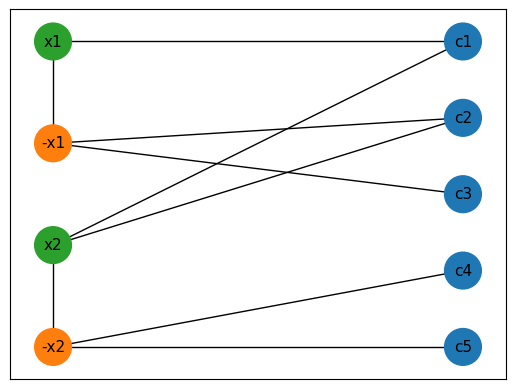

In [31]:
g.plot_nx()
print("Clauses:", g.to_clauses())
print("Valid merges:", g.get_valid_merges())


Clauses: [[1], [1, 2], [2], [2], [3], [-1], [-2], [-3]]
Valid merges: [(7, 10), (7, 13), (6, 8), (6, 9), (6, 10), (6, 12), (6, 13), (8, 10), (8, 11), (8, 13), (9, 10), (9, 11), (9, 13), (10, 11), (10, 12), (11, 12), (11, 13), (12, 13)]


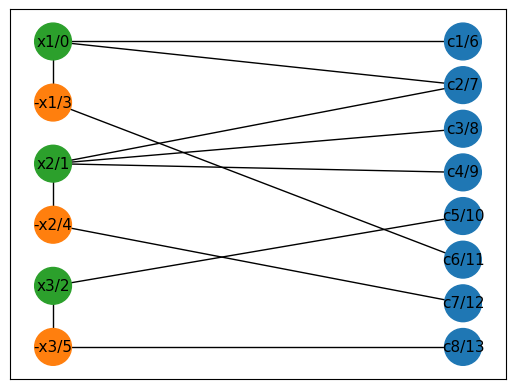

In [5]:
g.merge(*random.choice(g.get_valid_merges()))
g.plot_nx()
print("Clauses:", g.to_clauses())
print("Valid merges:", g.get_valid_merges())


Clauses: [[1, 2, -3], [1, 2], [2, 3, -1], [-2]]
Valid merges: []


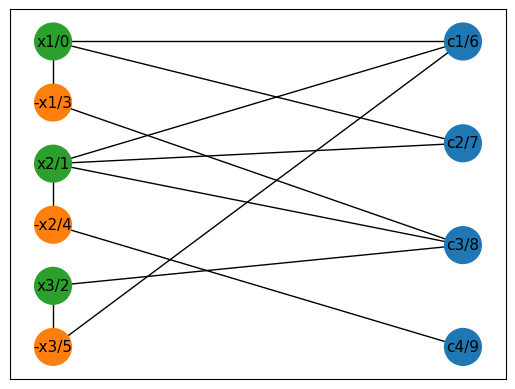

In [6]:
while not g.is_3sat():
    valid = g.get_valid_merges()
    if not valid:
        break
    g.merge(*random.choice(valid))

g.plot_nx()
print("Clauses:", g.to_clauses())
print("Valid merges:", g.get_valid_merges())


{'sample_time': 0.00034466900979168713, 'step_time': 0.0006170470005599782}

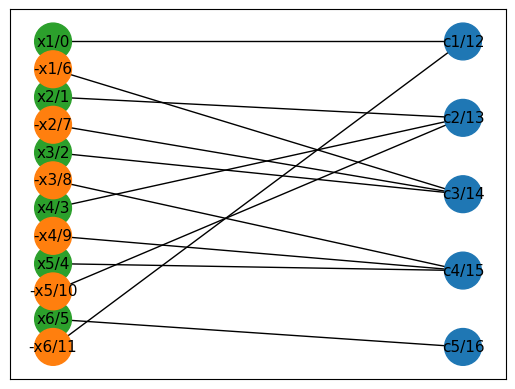

In [4]:
env = G2SATEnv(6, 4, PySAT("minisat22"), "decisions")
obs, _ = env.reset()

terminated = False
while not terminated:
    obs, _, terminated, _, info = env.step(random.choice(obs["valid_actions"]))
env.render()
info


## RL

In [35]:
env = G2SATEnv(10, 42, PySAT("minisat22"), "time_cpu", compress_observations=True, intermediate_rewards=False)
model = SAGE(
    input_dim=1 if env.compress_observations else 3,
    feature_dim=32,
    hidden_dim=32,
    output_dim=32,
    num_embeddings=3 if env.compress_observations else None,
    num_layers=3,
)#.to('cuda')
policy = G2SATPolicy(env, model, random_state=42)


In [36]:
env.reset()

({'graph': GraphInstance(nodes=array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
         2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]), edges=None, edge_links=array([[  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,   0,   0,   0,
            0,   0,   0,   0,   1,   1,   2,   2,   2,   2,   2,   3,   3,
            4,   4,   4,   4,   4,   4,   4,   4,   4,   5,   5,   5,   5,
            5,   5,   5,   5,   5,   5,   5,   5,   6,   6,   6,   6,   6,
            6,   6,   6,   6,   7,   7,   7,   7,   8,   8,   8,   8,   8,
            8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   8,   

In [11]:
history = train_reinforce(
    policy,
    optimizer=optim.AdamW(model.parameters(), lr=3e-4),
    return_trajectory=True,
    num_episodes=5,
)


Training:   0%|          | 0/5 [00:00<?, ?episodes/s]

In [16]:
history[0]["step_info"][1]

{'is_3sat': False,
 'metrics': {},
 'timing': {'step': 0.0006133720016805455,
  'sample_pairs': 0.00039473999640904367,
  'predict': 0.006760022006346844},
 'reward': 0,
 'log_prob': -9.306718826293945,
 'action': (26, 78)}

In [17]:
history

[{'loss': 0.009099619463086128,
  'return/shaped': 1.0185625928169337e-05,
  'return/original': 1.0185625928169343e-05,
  'step_info': [{'is_3sat': False,
    'metrics': {},
    'timing': {'step': 0.000487859986606054,
     'sample_pairs': 0.0003058639995288104,
     'predict': 0.006306052004219964},
    'reward': 0,
    'log_prob': -9.368847846984863,
    'action': (116, 139)},
   {'is_3sat': False,
    'metrics': {},
    'timing': {'step': 0.0006133720016805455,
     'sample_pairs': 0.00039473999640904367,
     'predict': 0.006760022006346844},
    'reward': 0,
    'log_prob': -9.306718826293945,
    'action': (26, 78)},
   {'is_3sat': False,
    'metrics': {},
    'timing': {'step': 0.0006427219923352823,
     'sample_pairs': 0.00040581999928690493,
     'predict': 0.011937940987991169},
    'reward': 0,
    'log_prob': -9.34799861907959,
    'action': (71, 97)},
   {'is_3sat': False,
    'metrics': {},
    'timing': {'step': 0.0006790570041630417,
     'sample_pairs': 0.00038118800

In [6]:
import pickle

In [18]:
len(pickle.dumps(history)) / 5 / 1024**2 * 2000

16.213607788085938

In [19]:
import pandas as pd

In [24]:
def flatten_dict(history, prefix="", out=None):
    if out is None:
        out = {}
    for k, v in history.items():
        k = prefix + k
        if isinstance(v, dict):
            flatten_dict(v, prefix=k + "/", out=out)
        else:
            out[k] = v
    return out


history_flat = [flatten_dict(h) for h in history]


In [37]:
pd.DataFrame([flatten_dict(x) for x in history[0]['step_info']]).to_csv('out.csv')

In [35]:
len(pickle.dumps(history[0]['step_info'])) / 1024

8.416015625

In [67]:
# dir = '../runs/SAGE/2023-07-24T19:11:14'
dir = '../runs/SAGE/2023-07-24T19:17:43'
dir = '../runs/SAGE/2023-07-24T19:20:49'
df_step = pd.read_csv(dir + '/history_step.csv')
df_episode = pd.read_csv(dir + '/history_episode.csv')

In [69]:
df_episode["timing/logger"].sum() #/ (df_step["timing/step"].sum() + df_step["timing/predict"].sum())

3.894950088841142

In [64]:
df_episode["timing/logger"].sum() / (df_step["timing/step"].sum() + df_step["timing/predict"].sum())

0.005553004116917134

In [62]:
df_episode["timing/logger"].sum() / (df_step["timing/step"].sum() + df_step["timing/predict"].sum())

0.0878591572600412